# KNN classification and comparison

In [1]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from tqdm import tqdm
import seaborn as sns

import Abed_utils
from facebookresearch_dino_main.eval_knn import knn_classifier as dino_knn
%matplotlib inline

## Feature Extraction
This is done in the file `extract_embeddings.py`. We simply store the output of the model and the label for each tile
## Define KNN classifier

In [2]:
@torch.no_grad()
def distance_matrix(x, y=None, p = 2): #pairwise distance of vectors

    y = x if type(y) == type(None) else y
    x = x.cpu()
    y = y.cpu()

    n = x.size(0)
    m = y.size(0)
    d = x.size(1)

    x = x.unsqueeze(1).expand(n, m, d)
    y = y.unsqueeze(0).expand(n, m, d)

    dist = torch.pow(x - y, p).sum(2)

    return dist

@torch.no_grad()
def knn_classifier(train_features:torch.Tensor, train_labels, test_features, test_labels, k:int):

    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    preds = torch.zeros_like(test_labels).cpu()

    for idx in range(0, num_test_images, imgs_per_chunk):
        features = test_features[idx:min(idx+imgs_per_chunk, num_test_images), :].cpu()
        targets = test_labels[idx:min(idx+imgs_per_chunk, num_test_images)].cpu()
        dists = distance_matrix(features, train_features)
        _, voters = torch.topk(dists, k, largest=False)
        votes = torch.gather(train_labels.view(1, -1).expand(targets.shape[0], -1),1, voters)
        batch_preds, _ = torch.mode(votes, 1)
        preds[idx : min((idx + imgs_per_chunk), num_test_images)] = batch_preds

    return preds

@torch.no_grad()
def similarity_knn_classifier(train_features:torch.Tensor, train_labels:torch.Tensor, test_features:torch.Tensor, test_labels:torch.Tensor, k:int):

    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    train_feats_transpose = train_features.t()

    preds = torch.zeros_like(test_labels)
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[idx:min((idx+imgs_per_chunk), num_test_images), :]
        targets = test_labels[idx:min((idx+imgs_per_chunk), num_test_images)]
        similarities = features.mm(train_feats_transpose).t().div(features.norm(2,1)).t().div(train_features.norm(2,1))
        _, voters = torch.topk(similarities, k, 1)
        votes = torch.gather(train_labels.view(1, -1).expand(targets.shape[0], -1),1, voters)
        batch_preds, _ = torch.mode(votes, 1)
        preds[idx : min((idx + imgs_per_chunk), num_test_images)] = batch_preds

    return preds


@torch.no_grad()
def weighted_similarity_knn_classifier(train_features, train_labels, test_features, test_labels, k, T, num_classes=1000):

    # top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).to(train_features.device)
    preds = torch.zeros_like(test_labels)
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        features = test_features[
            idx : min((idx + imgs_per_chunk), num_test_images), :
        ]
        targets = test_labels[idx : min((idx + imgs_per_chunk), num_test_images)]
        batch_size = targets.shape[0]

        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features)
        distances, indices = similarity.topk(k, largest=True, sorted=True)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        distances_transform = distances.clone().div_(T).exp_()
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        _, predictions = probs.sort(1, True)
        # return predictions
        # print(predictions.shape)
        preds[idx:min(idx+imgs_per_chunk, num_test_images)] = predictions[:,-1]

        # find the predictions that match the target
        # correct = predictions.eq(targets.data.view(-1, 1))
        # top1 = top1 + correct.narrow(1, 0, 1).sum().item()
        # top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        # total += targets.size(0)
    return preds
    # top1 = top1 * 100.0 / total
    # top5 = top5 * 100.0 / total
    # return top1, top5

## Load features and labels

In [3]:
feat_path = os.path.join(Abed_utils.OUTPUT_ROOT, 'features-k19-trained-42')

features, labels = Abed_utils.load_features(feat_path, cuda=True)

print(f'features is of shape {features.shape} and is on {features.device}')
print(f'labels is of shape {labels.shape} and is on {labels.device}')

features is of shape torch.Size([100000, 192]) and is on cuda:0
labels is of shape torch.Size([100000]) and is on cuda:0


In [4]:
# K-Fold CV
seed = 42
n_folds = 10
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

k_fold = KFold(n_splits=n_folds, random_state=seed, shuffle=True)

features = features.to(device)
labels = labels.to(device)

0it [00:00, ?it/s]

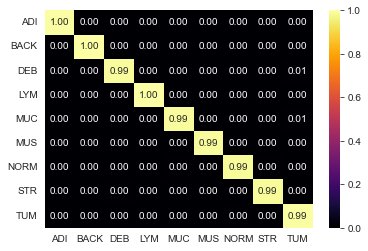

1it [00:02,  2.07s/it]

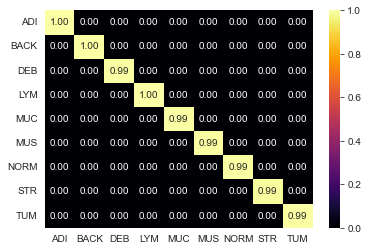

2it [00:03,  1.51s/it]

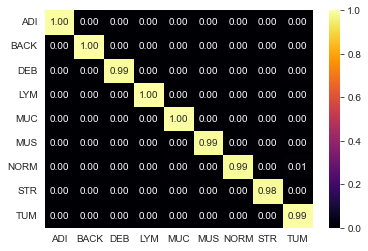

3it [00:04,  1.34s/it]

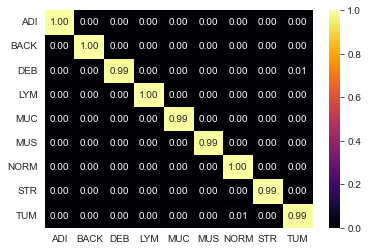

4it [00:05,  1.25s/it]

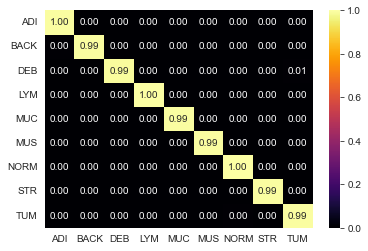

5it [00:06,  1.18s/it]

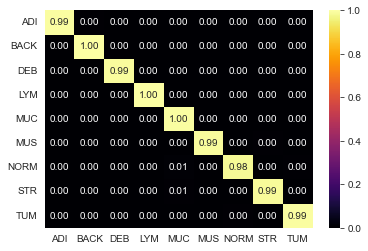

6it [00:07,  1.16s/it]

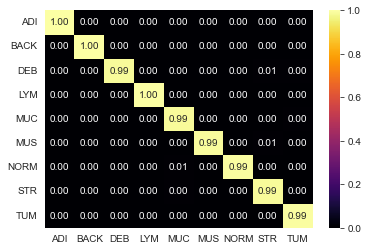

7it [00:08,  1.18s/it]

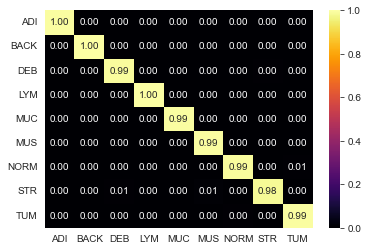

8it [00:09,  1.16s/it]

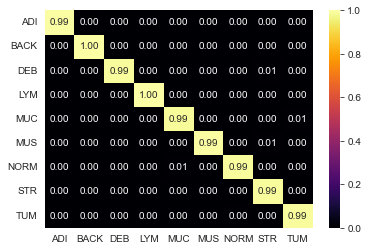

9it [00:11,  1.14s/it]

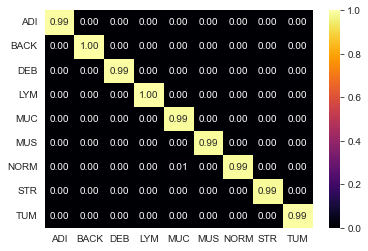

10it [00:12,  1.22s/it]

10-fold CV shows:
average accuracy: 99.31%, average f1: 0.99 for cos similarity KNN,



In [5]:
# Parameter for KNN classification
K = 20
acc_sim = []
acc_weighted = []
acc_base = []
f1_sim = []
f1_weighted = []
f1_base = []
acc_dino = []
acc_dino_5 = []
# auc_base = []
# auc_weighted = []

base_knn = KNeighborsClassifier(K)

for train_idx, val_idx in tqdm(k_fold.split(features, labels)):
    X_train, X_test = features[train_idx], features[val_idx]
    y_train, y_test = labels[train_idx], labels[val_idx]

    y_test_cpu = y_test.cpu()

    # preds_sim = Abed_utils.KNNClassifier(X_train, y_train, K)(X_test).cpu()
    preds_sim = similarity_knn_classifier(X_train, y_train, X_test, y_test, K).cpu()
    # preds_weighted = weighted_similarity_knn_classifier(X_train, y_train, X_test, y_test, K, 0.07, 9).cpu()
    # preds_base = base_knn.fit(X_train.cpu(), y_train.cpu()).predict(X_test.cpu())

    acc_sim.append(preds_sim.eq(y_test_cpu).float().mean())
    f1_sim.append(f1_score(y_test_cpu, preds_sim, average='micro'))

    cmatrix = confusion_matrix(y_test_cpu, preds_sim, normalize='true')

    sns.heatmap(cmatrix, cmap='inferno', annot=True, fmt='.2f', vmin=0, vmax=1,
                    xticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'],
                    yticklabels=['ADI', 'BACK', 'DEB', 'LYM', 'MUC', 'MUS', 'NORM', 'STR', 'TUM'])
    plt.show()

    # auc_base.append(roc_auc_score(y_test_cpu, preds_base, average='micro', multi_class='ovr'))

    # acc_weighted.append(preds_weighted.eq(y_test_cpu).float().mean())
    # f1_weighted.append(f1_score(y_test_cpu, preds_weighted, average='micro'))
    # # auc_weighted.append(roc_auc_score(y_test_cpu, preds_weighted, average='micro', multi_class='ovr'))
    #
    # acc_base.append((preds_base == y_test_cpu.numpy()).mean())
    # f1_base.append(f1_score(y_test_cpu, preds_base, average='micro'))

    # acc, acc5 = dino_knn(X_train, y_train, X_test, y_test, K, 0.07, 9)
    # acc_dino.append(acc)
    # acc_dino_5.append(acc5)

print(f'{n_folds}-fold CV shows:\n'
      f'average accuracy: {100*np.mean(acc_sim):.2f}%, average f1: {np.mean(f1_sim):.2f} for cos similarity KNN,\n')
      # f'average accuracy: {100*np.mean(acc_weighted):.2f}%, average f1: {np.mean(f1_weighted):.2f} for weighted KNN,\n'
      # f'average accuracy: {100*np.mean(acc_base):.2f}%, average f1: {np.mean(f1_base):.2f} for base KNN,\n')
      # f'average accuracy: {np.mean(acc_dino):.2f}% and a top5 acc: {np.mean(acc_dino_5)}% with the dino KNN implementation')